# Detect larger vocabulary for Object Detection
This following file intends to read out the captions for Gemini which we identify as our best caption and filter it based on nouns. 
First: use gemini_descriptions to filter out all the nouns and analyze afterwards if we should possibly remove stopwords
Afterwards: analyze this based on moondream as well


## Setup - install every necessary package from nltk 

In [1]:
# Imports and installation of nltk packages that are required
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from collections import Counter
from nltk.corpus import wordnet
import matplotlib.pyplot as plt


## Please install them if you run it for the first time
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_pe

True

### Extract necessary nouns and count the occurences of different words
For this analysis: sample of 10.000 images and their most common nouns. Display the first 100 in a graph.


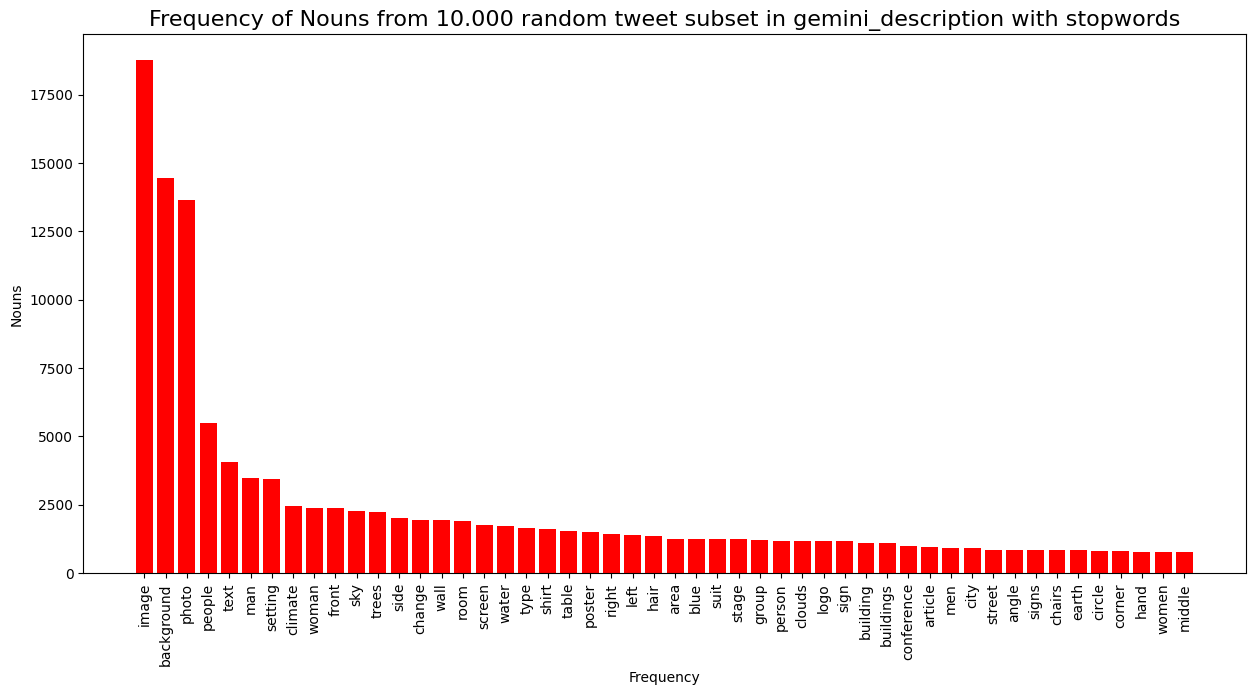

In [2]:
from openpyxl import Workbook

# first: analyze based on random image dataset
file_path = 'C:\\Users\\Admin\\Documents\\GitHub\\Team_Project_ComputerVision\\dataset_results\\current\\result_dino_randomsubset1.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

# We care about synonyms as we don't want to duplicate words
def get_synonym(word):
    synonyms = wordnet.synsets(word)
    return synonyms

def extract_nouns(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    nouns = [word.lower() for word, pos in pos_tags if pos.startswith('NN')] # NN stands for "noun"
    return nouns


descriptions = df['gemini_description'].dropna()

all_nouns = []
for description in descriptions:
    nouns = extract_nouns(description)
    all_nouns.extend(nouns)
    

noun_counts = Counter(all_nouns)
most_common_nouns = noun_counts.most_common(50)

# Separate the data into nouns and counts for easier plotting
nouns, counts = zip(*most_common_nouns)

# Create a bar plot
plt.figure(figsize=(15, 7))
plt.bar(nouns, counts, color='red')

# Add titles and labels
plt.title('Frequency of Nouns from 10.000 random tweet subset in gemini_description with stopwords', fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Nouns')
plt.xticks(rotation=90)


# Show the plot
plt.show()

### The same as above but with the addition of removing stopwords

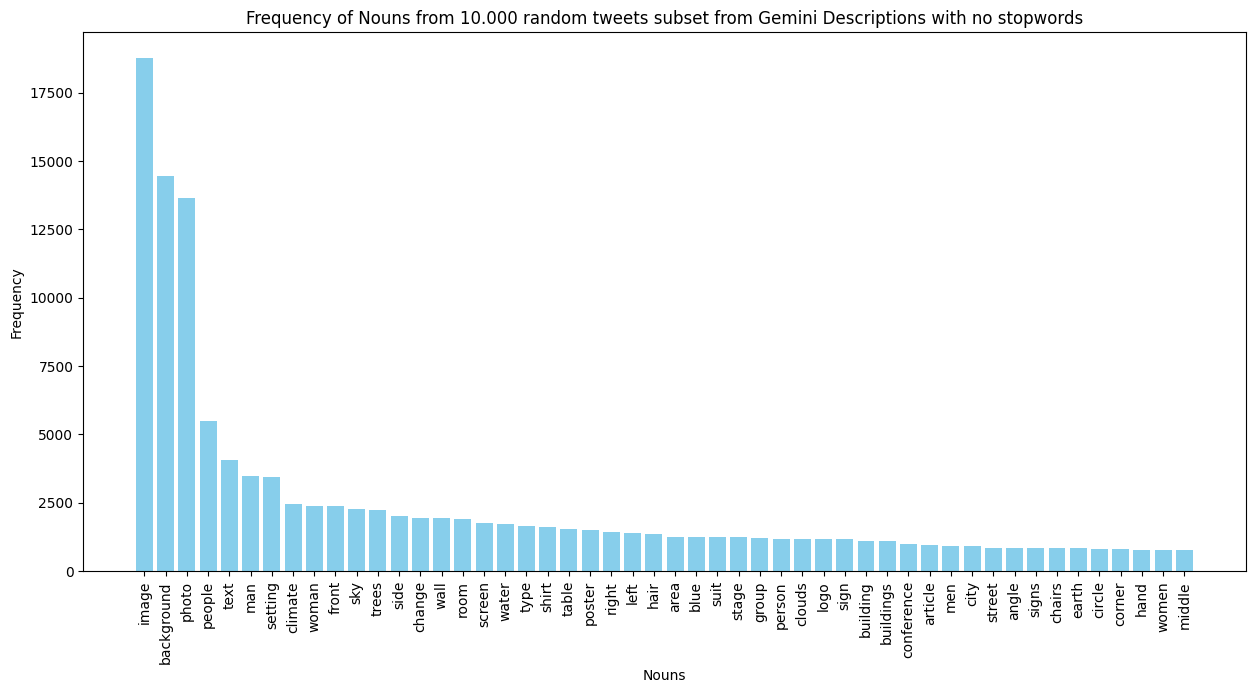

In [5]:
stop_words = set(stopwords.words('english'))
filtered_nouns = [noun for noun in all_nouns if noun not in stop_words]
noun_counts = Counter(filtered_nouns)
most_common_nouns = noun_counts.most_common()

wb = Workbook()
ws = wb.active
header = ['noun', 'count']
ws.append(header)

nouns = []
counts = []

## For Excel: all most common nouns
for noun, count in most_common_nouns:
    data_row = [noun, count]
    ws.append(data_row)

wb.save('noun_count_result_randomsubset_gemini_no_stopwords.xlsx')

## For graph: 100 most common
most_common_nouns_graph = noun_counts.most_common(50)
for noun, count in most_common_nouns_graph:
    nouns.append(noun)
    counts.append(count)

plt.figure(figsize=(15, 7))
plt.bar(nouns, counts, color='skyblue')


plt.title('Frequency of Nouns from 10.000 random tweets subset from Gemini Descriptions with no stopwords')
plt.xlabel('Nouns')
plt.ylabel('Frequency')
plt.xticks(rotation=90)


# Show the plot
plt.show()


### Manual Analysis of gemini nouns
For us it is interesting to analyze nouns that appear often in image descriptions as they can be potential candidates for our GroundingDINO vocabulary. This vocabulary is interested in objects that can cause us to derive meaningful information tweets regarding the topic climate change.

At the beginning, it is important to understand what kind of nouns might be interesting. Overall, it can be animals or specific objects that are easy to identify and not some sort of concepts that are hard to define. An example would be a tree is easy to identify as it is an object with a trunk, branches and leaves while a forest might be hard to classify as it is a concept which entails several objects. Moreover, stopwords are clearly not important as they tend to be filler words with no large meaning that we want to represent. Consequently, we filtered those out of the list of nouns. Furthermore, the words should be common in the context of climate change - thus it makes no sense to use words that are occurring less than 100 times in a dataset of 10.000 images.

All in all, we are mostly interested in objects that matter from a climate change standpoint and are occuring relatively often as a too large vocabulary and especially an overlapping vocabulary could lead to low confidence and confusions in detections.

Looking at the graph above, the most common nouns like image, background, photo and text are either not easily detectable by these models or don't have a semantic meaning for us. For instance, what do we derive from an image having the object 'text'? This text could be a lot of things - something as part of a sign in a protest or on a phone. It basically does not give us the information we care about. In comparison, people are interesting and a large count of them could make us for instance derive that a place is 'crowded' which could mean it's an event. Though, we want to generalize the genders and people/person as one object 'person' as genders are hard to detect and matter not much in our context. Moreover, screen, water, sign and building are further objects that can be included. 

Based on the results seen in the graph and complete excel file of nouns, we decided that only popular words which occurred more than 50 times in the small dataset should be included in the vocabulary that make sense in our context. We decided against lemmatization as it makes it hard to backtrack certain word stems and we found it easy enough to track plurals by ourselves when doing the manual analysis. Furthermore, in our context it makes less sense as we use only nouns so it can't be the case that we have a lot of forms from e.g. 'play' as 'playing', 'played', 'plays' etc. are out of the equation. 

Based on our analysis, we added the several words including the following words to our previous vocabulary. 
[screen, podium, sign, map, diagram, mountain, snow, flag, hurricane, building]

Finally, this analysis also showed that our previous vocabularly primarily contained frequently used words in the text captions. For every single previous entry, we re-evaluated their relevance with this analysis. If the occurence was quite low (below 50), then it seems like the focus was inproperly set.


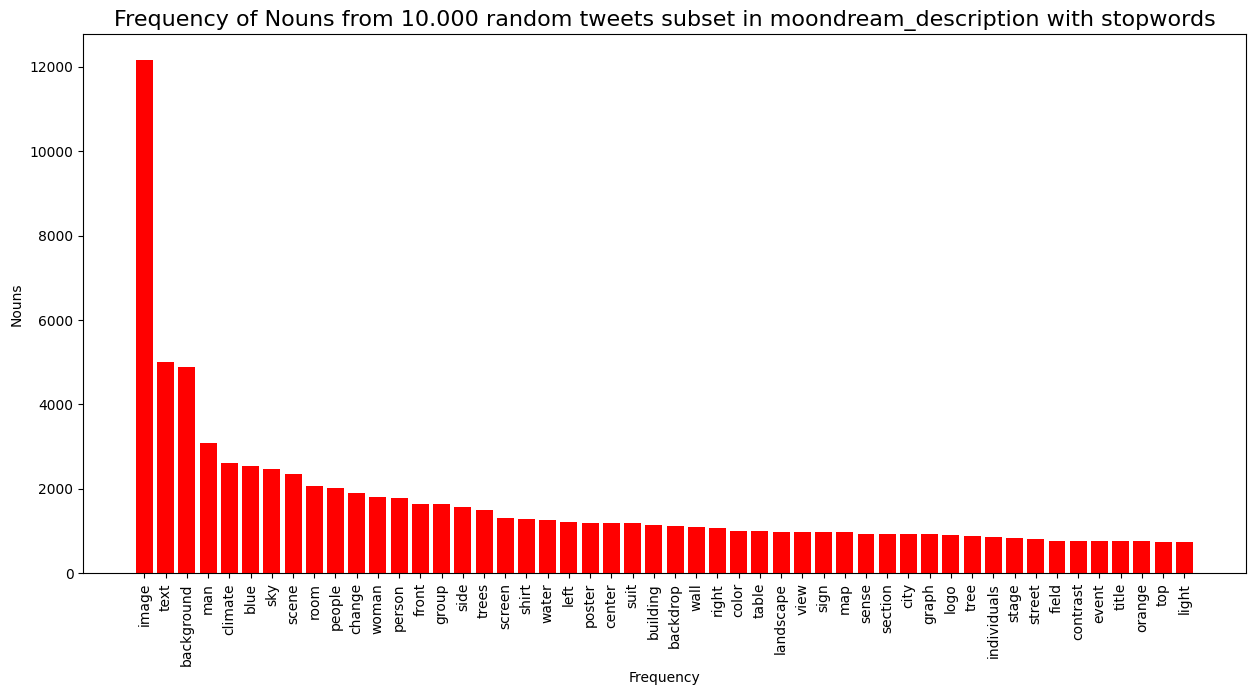

In [11]:
from openpyxl import Workbook

# We care about synonyms as we don't want to duplicate words
def get_synonym(word):
    synonyms = wordnet.synsets(word)
    return synonyms

def extract_nouns(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    nouns = [word.lower() for word, pos in pos_tags if pos.startswith('NN')] # NN stands for "noun"
    return nouns


descriptions = df['moondream_description'].dropna()

all_nouns = []
for description in descriptions:
    nouns = extract_nouns(description)
    all_nouns.extend(nouns)
    

noun_counts = Counter(all_nouns)
most_common_nouns = noun_counts.most_common(50)

# Separate the data into nouns and counts for easier plotting
nouns, counts = zip(*most_common_nouns)

# Create a bar plot
plt.figure(figsize=(15, 7))
plt.bar(nouns, counts, color='red')

# Add titles and labels
plt.title('Frequency of Nouns from 10.000 random tweets subset in moondream_description with stopwords', fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Nouns')
plt.xticks(rotation=90)


# Show the plot
plt.show()

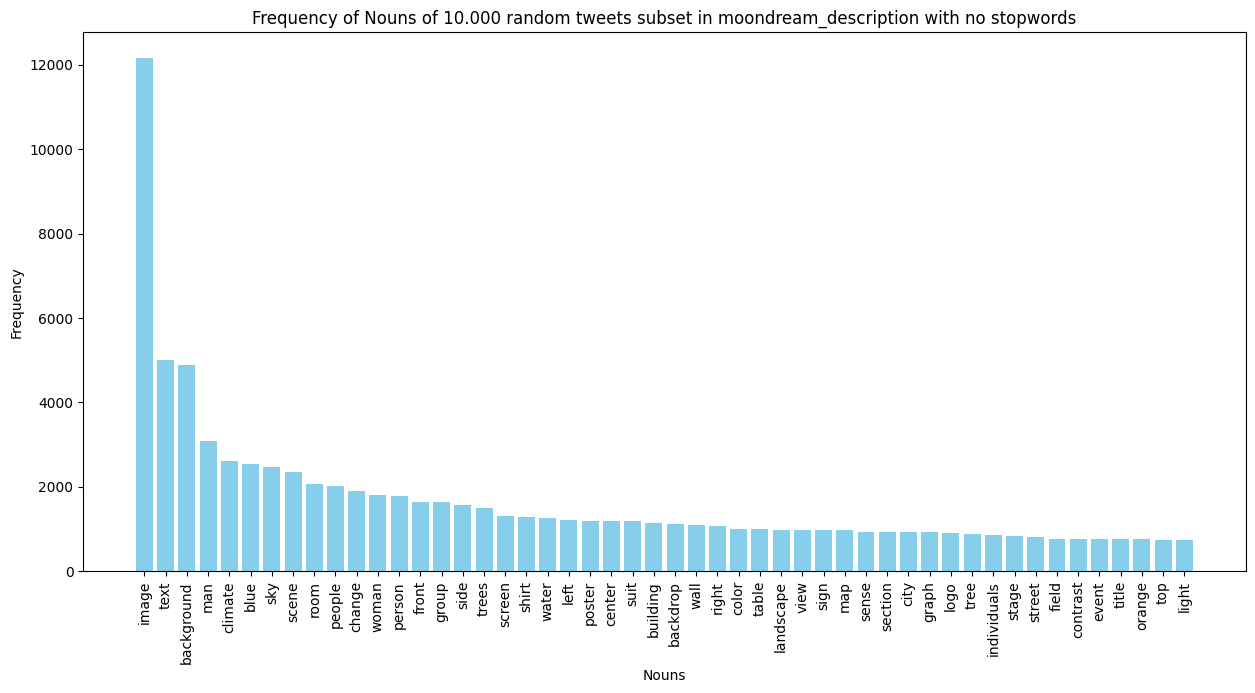

In [12]:
stop_words = set(stopwords.words('english'))
filtered_nouns = [noun for noun in all_nouns if noun not in stop_words]
noun_counts = Counter(filtered_nouns)
most_common_nouns = noun_counts.most_common()

wb = Workbook()
ws = wb.active
header = ['noun', 'count']
ws.append(header)

nouns = []
counts = []

## For Excel: all most common nouns
for noun, count in most_common_nouns:
    data_row = [noun, count]
    ws.append(data_row)

wb.save('noun_count_result_randomsubset_moondream_no_stopwords.xlsx')

## For graph: 100 most common
most_common_nouns_graph = noun_counts.most_common(50)
for noun, count in most_common_nouns_graph:
    nouns.append(noun)
    counts.append(count)

plt.figure(figsize=(15, 7))
plt.bar(nouns, counts, color='skyblue')


plt.title('Frequency of Nouns of 10.000 random tweets subset in moondream_description with no stopwords')
plt.xlabel('Nouns')
plt.ylabel('Frequency')
plt.xticks(rotation=90)


# Show the plot
plt.show()


### Manual Analysis of moondreamv2 nouns
Compared to gemini, moondreamv2 has more nouns that are above 100 uses. This could be the case due to the vocabulary being quite a bit lower with 11.400 instead of around 15.606 nouns. Gemini seems to have a more diverse vocabulary.

In this case we also did the same approach as with gemini. First of all, we ensured our current vocabulary is well represented in the dataset overall according to moondreamv2. Afterwards, we look at the vocabulary based on frequency and try to extend the vocabulary.

Some nouns that were added included: landscape (e.g. nature-based picture might be interesting to classify), camera (if something is relevant to be recorded), microphone (e.g. in a protest when one person speaks up) and book

# Analyze the nouns of the 5000 most liked tweets


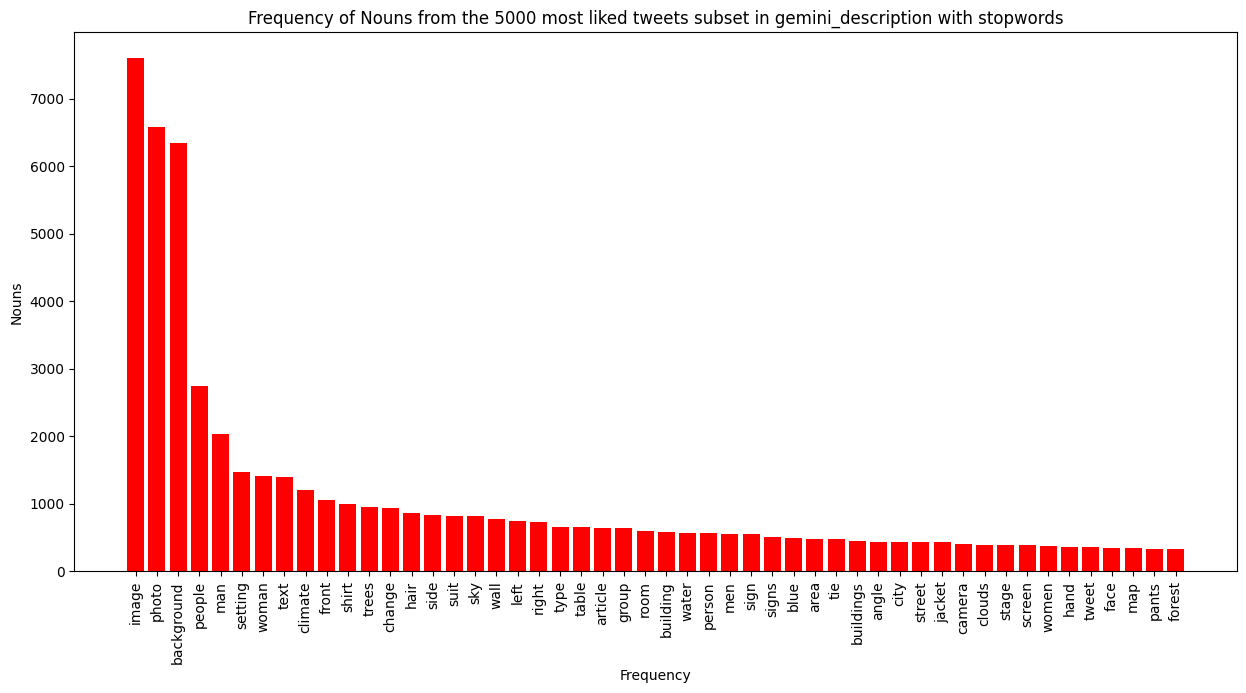

In [13]:
from openpyxl import Workbook

# first: analyze based on random image dataset
file_path = 'C:\\Users\\Admin\\Documents\\GitHub\\Team_Project_ComputerVision\\dataset_results\\current\\result_dino_mostlikeddataset.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

# We care about synonyms as we don't want to duplicate words
def get_synonym(word):
    synonyms = wordnet.synsets(word)
    return synonyms

def extract_nouns(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    nouns = [word.lower() for word, pos in pos_tags if pos.startswith('NN')] # NN stands for "noun"
    return nouns


descriptions = df['gemini_description'].dropna()

all_nouns = []
for description in descriptions:
    nouns = extract_nouns(description)
    all_nouns.extend(nouns)
    

noun_counts = Counter(all_nouns)
most_common_nouns = noun_counts.most_common(50)

# Separate the data into nouns and counts for easier plotting
nouns, counts = zip(*most_common_nouns)

# Create a bar plot
plt.figure(figsize=(15, 7))
plt.bar(nouns, counts, color='red')

# Add titles and labels
plt.title('Frequency of Nouns from the 5000 most liked tweets subset in gemini_description with stopwords')
plt.xlabel('Frequency')
plt.ylabel('Nouns')
plt.xticks(rotation=90)


# Show the plot
plt.show()

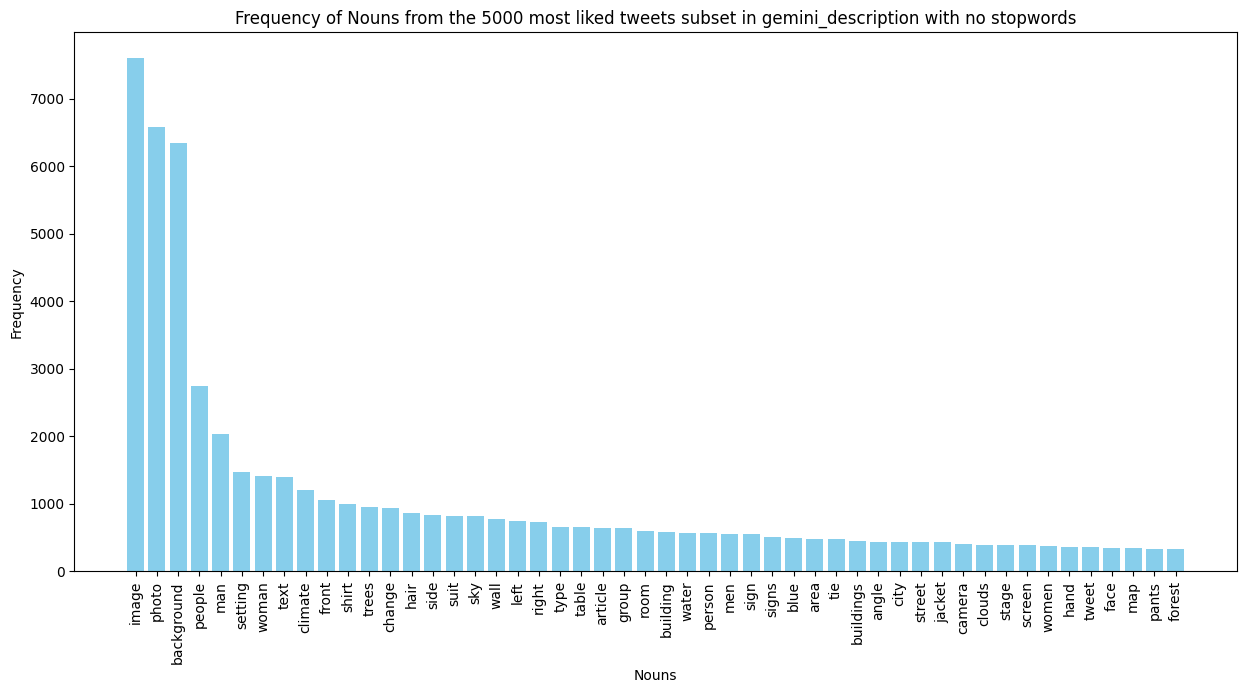

In [14]:
stop_words = set(stopwords.words('english'))
filtered_nouns = [noun for noun in all_nouns if noun not in stop_words]
noun_counts = Counter(filtered_nouns)
most_common_nouns = noun_counts.most_common()

wb = Workbook()
ws = wb.active
header = ['noun', 'count']
ws.append(header)

nouns = []
counts = []

## For Excel: all most common nouns
for noun, count in most_common_nouns:
    data_row = [noun, count]
    ws.append(data_row)

wb.save('noun_count_result_gemini_mostliked_no_stopwords.xlsx')

## For graph: 100 most common
most_common_nouns_graph = noun_counts.most_common(50)
for noun, count in most_common_nouns_graph:
    nouns.append(noun)
    counts.append(count)

plt.figure(figsize=(15, 7))
plt.bar(nouns, counts, color='skyblue')


plt.title('Frequency of Nouns from the 5000 most liked tweets subset in gemini_description with no stopwords')
plt.xlabel('Nouns')
plt.ylabel('Frequency')
plt.xticks(rotation=90)


# Show the plot
plt.show()


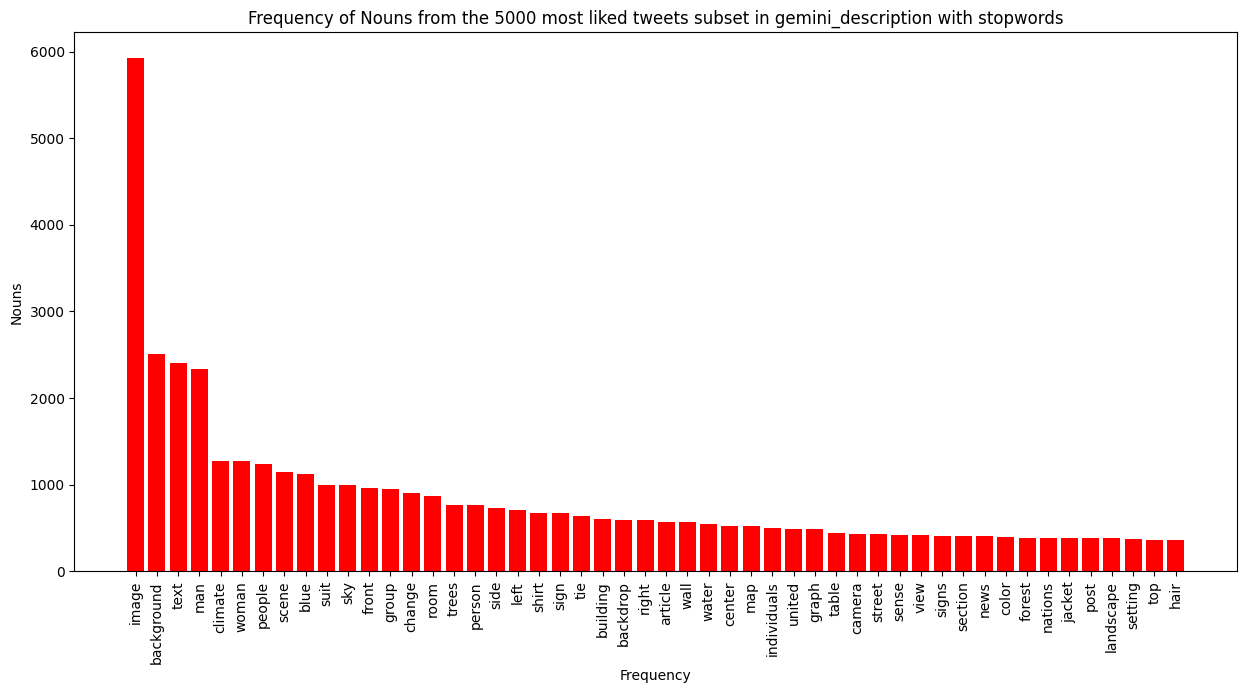

In [15]:
from openpyxl import Workbook

# We care about synonyms as we don't want to duplicate words
def get_synonym(word):
    synonyms = wordnet.synsets(word)
    return synonyms

def extract_nouns(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    nouns = [word.lower() for word, pos in pos_tags if pos.startswith('NN')] # NN stands for "noun"
    return nouns


descriptions = df['moondream_description'].dropna()

all_nouns = []
for description in descriptions:
    nouns = extract_nouns(description)
    all_nouns.extend(nouns)
    

noun_counts = Counter(all_nouns)
most_common_nouns = noun_counts.most_common(50)

# Separate the data into nouns and counts for easier plotting
nouns, counts = zip(*most_common_nouns)

# Create a bar plot
plt.figure(figsize=(15, 7))
plt.bar(nouns, counts, color='red')

# Add titles and labels
plt.title('Frequency of Nouns from the 5000 most liked tweets subset in gemini_description with stopwords')
plt.xlabel('Frequency')
plt.ylabel('Nouns')
plt.xticks(rotation=90)


# Show the plot
plt.show()

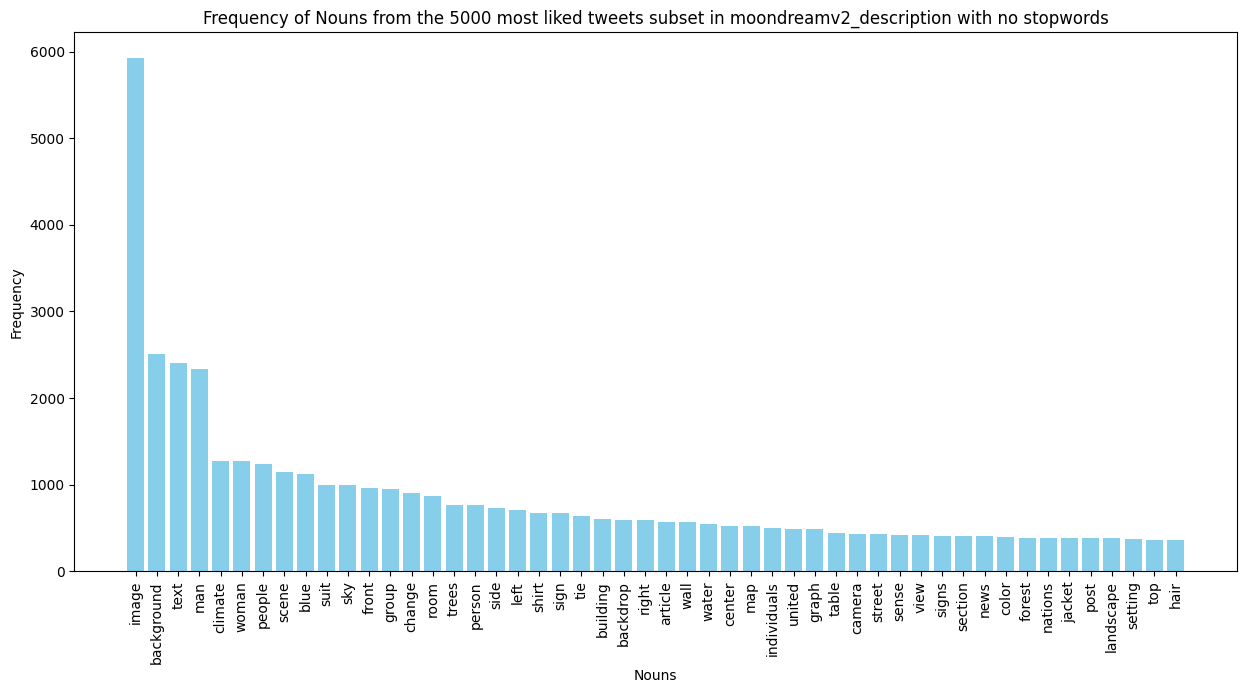

In [16]:
stop_words = set(stopwords.words('english'))
filtered_nouns = [noun for noun in all_nouns if noun not in stop_words]
noun_counts = Counter(filtered_nouns)
most_common_nouns = noun_counts.most_common()

wb = Workbook()
ws = wb.active
header = ['noun', 'count']
ws.append(header)

nouns = []
counts = []

## For Excel: all most common nouns
for noun, count in most_common_nouns:
    data_row = [noun, count]
    ws.append(data_row)

wb.save('noun_count_result_moondream_mostliked_no_stopwords.xlsx')

## For graph: 100 most common
most_common_nouns_graph = noun_counts.most_common(50)
for noun, count in most_common_nouns_graph:
    nouns.append(noun)
    counts.append(count)

plt.figure(figsize=(15, 7))
plt.bar(nouns, counts, color='skyblue')


plt.title('Frequency of Nouns from the 5000 most liked tweets subset in moondreamv2_description with no stopwords')
plt.xlabel('Nouns')
plt.ylabel('Frequency')
plt.xticks(rotation=90)


# Show the plot
plt.show()
